# **Multiclass classification with hipe4ml**

The goal of this tutorial is to provide an example of multiclass classification with machine learing techniques using the package [hipe4ml](https://hipe4ml.github.io/).

This tutorial is based on the particle identification using the information of the particle energy loss $\mathrm{d}E/\mathrm{d}x$ in the ITS and TPC detectors of the ALICE experiment in Run 1. The data were collected by ALICE in 2010 and correspond to 240 million minimum-bias pp collisions at $\sqrt{s}$ = 7 TeV. In this data sample 200000 electrons, pions, kaons, protons, and deuterons were selected with different techniques. In particular, pions were selected via $\mathrm{K_S^0}\rightarrow\mathrm{\pi^+\pi^-}$ decays, protons via $\Lambda\rightarrow\mathrm{p\pi^-}$ decays, kaons via the kink topology of $\mathrm{K^+}\rightarrow\mathrm{\pi^+\nu_\mu}$ decays, electrons via $\gamma\rightarrow\mathrm{e^+e^-}$ conversions, and deuterons using the information from the time-of-flight detector.

All the data samples can be found at:

- pions: https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/pi_fromV0_data_filtered.parquet.gzip
- kaons: https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/kaons_fromkinks_data_filtered.parquet.gzip 
- protons: https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/protons_fromL_data_filtered.parquet.gzip
- electrons: https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/electrons_fromconversions_data_filtered.parquet.gzip
- deuterons: https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/deuterons_fromTOFTPC_data_filtered.parquet.gzip

### **Prerequisites**

The following packages are needed to follow this tutorial and in general to use _hipe4ml_:

- [_uproot_](https://github.com/scikit-hep/uproot) is a reader and a writer of the ROOT file data format and is used to cast blocks of data from the ROOT file as Numpy arrays.

- _xxhash_ and _lz4_ are used to decompress the files after download.


In [1]:
%%capture
!pip install hipe4ml
!pip install uproot
!pip install xxhash
!pip install lz4

### **Restart Runtime(temporary)** 
Due to a conflict with the Colab pre-installed matplotlib package, it is required to restart the runtime before running the notebook. Restart the runtime with the command below and then go directly to the **File Download** section. Do not run the following cell if you are running the notebook in your local machine

In [ ]:
import os
os.kill(os.getpid(), 9)

### **File download**

All the files are downloaded from the repository.

In [1]:
%%capture
!curl -L https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/pi_fromV0_data_filtered.parquet.gzip?raw=true --output pions.parquet.gzip
!curl -L https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/kaons_fromkinks_data_filtered.parquet.gzip?raw=true --output kaons.parquet.gzip
!curl -L https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/protons_fromL_data_filtered.parquet.gzip?raw=true --output protons.parquet.gzip
!curl -L https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/electrons_fromconversions_data_filtered.parquet.gzip?raw=true --output electrons.parquet.gzip
!curl -L https://github.com/hipe4ml/hipe4ml_tests/blob/master/PID7TeV/deuterons_fromTOFTPC_data_filtered.parquet.gzip?raw=true --output deuterons.parquet.gzip

### **Required python packages**

The packages required for the tutorial are imported in the following.

In [95]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml.analysis_utils import train_test_generator
from hipe4ml import plot_utils

### **Preparing the training set and the test set**

All the data sets are in _parquet_ data format and are all obtained from real data taken by the ALICE Collaboration as described in the introduction. 

In [109]:
pions_hdl = TreeHandler("pions.parquet.gzip")
kaons_hdl = TreeHandler("kaons.parquet.gzip")
protons_hdl = TreeHandler("protons.parquet.gzip")
electrons_hdl = TreeHandler("electrons.parquet.gzip")
deuterons_hdl = TreeHandler("deuterons.parquet.gzip")

A _total set_ is built by merging the indivisual sets. A label is assigned to each candidate of the total set: 0 for pions, 1 for kaons, 2 for protons, 3 for electrons, and 4 for deuterons. The total set is split into a _train set_ and a _test set_, used for training and testing the algorithm, respectively. The fraction of the total set used as test set is defined by the _test_size_ parameter of the function [_sklearn.model_selection.train_test_split_](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [110]:
train_test_data = train_test_generator([pions_hdl, kaons_hdl, protons_hdl, electrons_hdl, deuterons_hdl], [0, 1, 2, 3, 4], test_size=0.5, random_state=42)

The distributions of the features for signal and background are plotted using the function _plot\_utils_._plot\_distr_ of _hipe4ml_. Similarly, the correlation matrix for the features is plotted with the function _plt\_utils_._plot\_corr_.


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


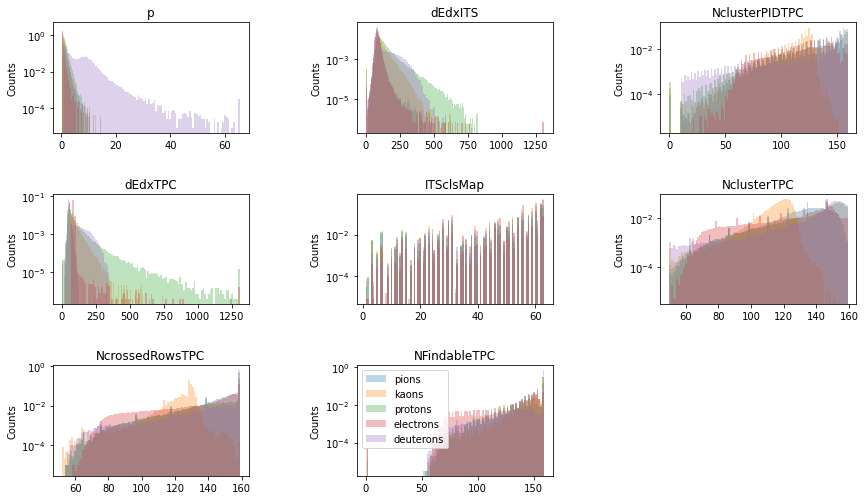

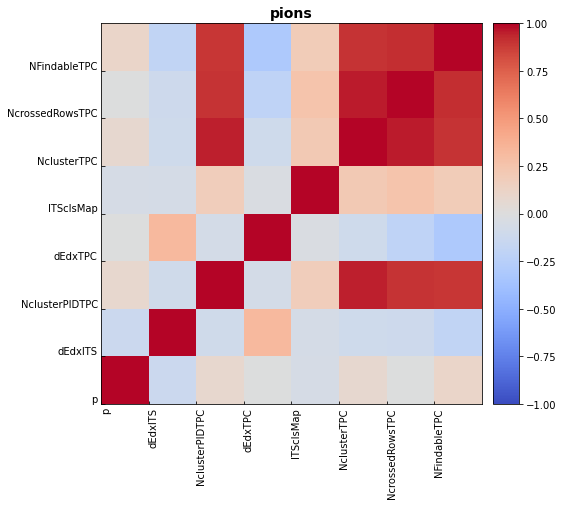

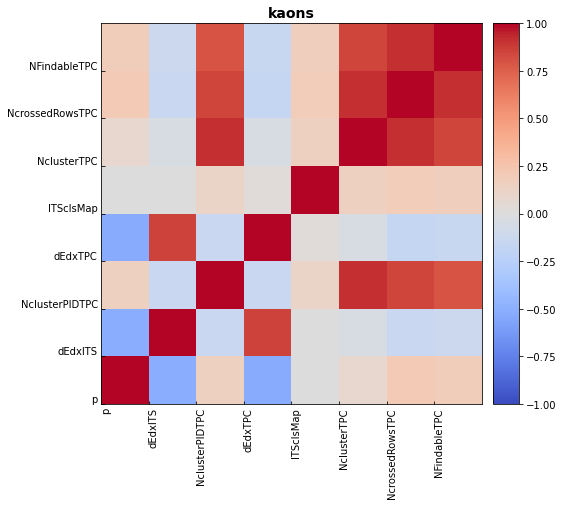

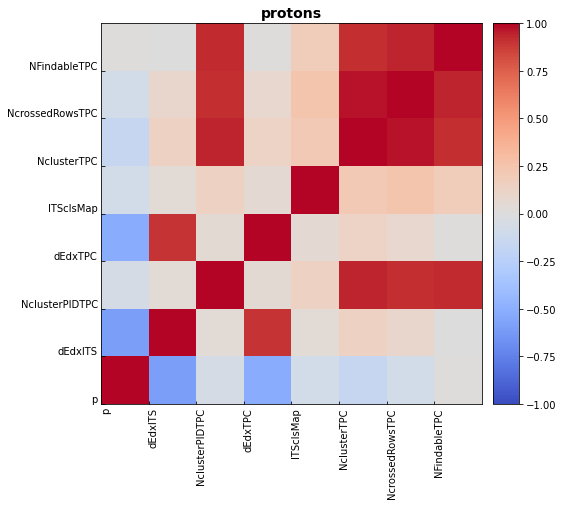

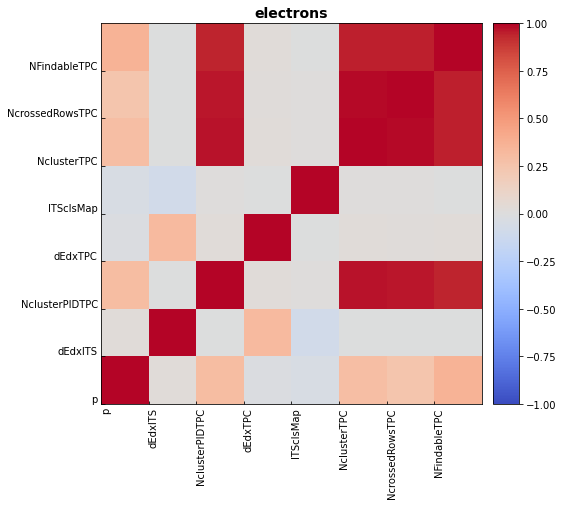

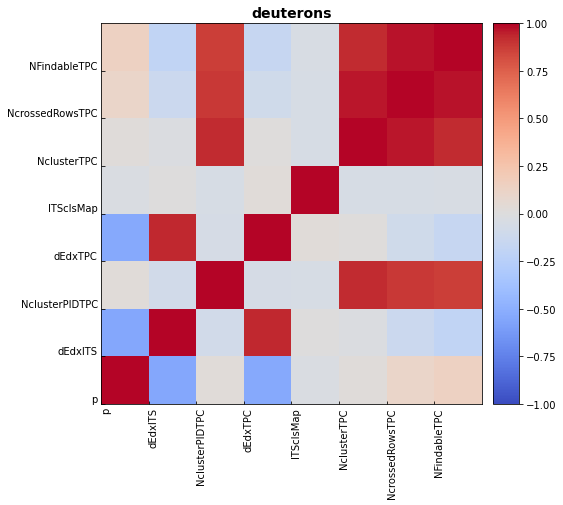

In [111]:
vars_to_draw = pions_hdl.get_var_names()
vars_to_draw.remove("pT")
vars_to_draw.remove("eta")
vars_to_draw.remove("phi")

leg_labels = ["pions", "kaons", "protons", "electrons", "deuterons"]

plot_utils.plot_distr([pions_hdl, kaons_hdl, protons_hdl, electrons_hdl, deuterons_hdl], vars_to_draw, bins=100, labels=leg_labels, log=True, density=True, figsize=(12, 7), alpha=0.3, grid=False)
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
plot_utils.plot_corr([pions_hdl, kaons_hdl, protons_hdl, electrons_hdl, deuterons_hdl], vars_to_draw, leg_labels)

plt.show()

In [112]:
features_for_train = vars_to_draw.copy()

### **The model**

For this example, [_XGBoost_](https://xgboost.readthedocs.io/en/latest/) is used as classification algorithm. XGBoost is an implementation of gradient boosted decision trees, designed to be highly efficient, flexible and portable.

The _hipe4ml_ package deals with the model through the _ModelHandler_ module. The model-handler is used to define the features used in the training process and to set the _hyperparameters_ of the model, such as the number of estimators, the maximum depth of the trees and the learning rate.



In [113]:
model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, features_for_train)

### **Optimisation of hyperparameters with Optuna**
The optimisation of the hyperparameters is a key step to obtain the best performance from the algorithm. In _hipe4ml_ the Optuna package is employed for the optimisation through the method _ModelHandler.optimize\_params\_optuna_. (<https://github.com/optuna/optuna>)

The Optuna package provides a wide choice of algorithms for the hyperparameter optimization. The default one is the TPESampler, which is known to provide robust performance in few iterations. The difference between other approaches, like grid search or random search, and the TPESampler optimisation is that the latter takes into account past evaluations when choosing the hyperparameter set to evaluate next.

A set of hyperparameters should be tested on different samples to avoid overfitting problems. Since the number of events is limited, an approach called _cross validation_ is used. It has been proved that the cross validation removes the dependence of the model on the data sample. 

In the cross validation procedure, the original sample is divided in _n_ parts called _folds_ (in this case 5 folds are used). For each set of hyperparameters, _n-1_ folds are used for the optimisation and the remaining one as test. This operation is repeated after permuting the folds used for optimisation and for testing and the final result is the mean value of all the permutations.

The ModelHandler automatically updates the hyperparameters after their optimisation.

This operation might take a rather long time, hence it can be skipped in this tutorial to spare time.

In [43]:
hyper_pars_ranges = {"n_estimators": (200, 1000), "max_depth": (2, 4), "learning_rate": (0.01, 0.1)}
model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring="roc_auc_ovo", timeout=5,
                                 n_jobs=-1, n_trials=100, direction="maximize")

[I 2022-04-01 09:45:58,269] A new study created in memory with name: no-name-fd34c695-801c-4d89-96e1-c9a9bff8d14b
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[09:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used wit

### **Training and testing the model**
The model training is performed with the method _ModelHandler.train\_test\_model_. It requires as argument a list containing:
1. the training set;
2. the real class label for the training set;
3. the test set;
4. the real class label for the test set.

In [116]:
model_hdl.train_test_model(train_test_data, multi_class_opt="ovo")

Number of detected classes: 5


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:44:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training the final model: Done!
Testing the model: Done!
ROC_AUC_score: 0.998169


The predictions for the training and the test sets are obtained with the _predict_ method of the _ModelHandler_ module.

In [117]:
y_pred_train = model_hdl.predict(train_test_data[0], False)
y_pred_test = model_hdl.predict(train_test_data[2], False)

The results of the training process can be observed by plotting the distributions of the BDT scores for the training and the test sets. The output consists of a score related to the probability to belong to each of the classes used for the training. This operation is performed with the method _plot\_utils_._plot\_output\_train\_test_.

The distributions of the model scores obtained from the test set are in good agreement with those obtained from the training set. This is a sign that tha model has been trained properly.

A disagreement between the distributions obtained from the training set and the datasets would reflect an overfitting by the classification algorithm: the classifier has learnt some characteristics that are peculiar of the training set but that are not true for a general sample.

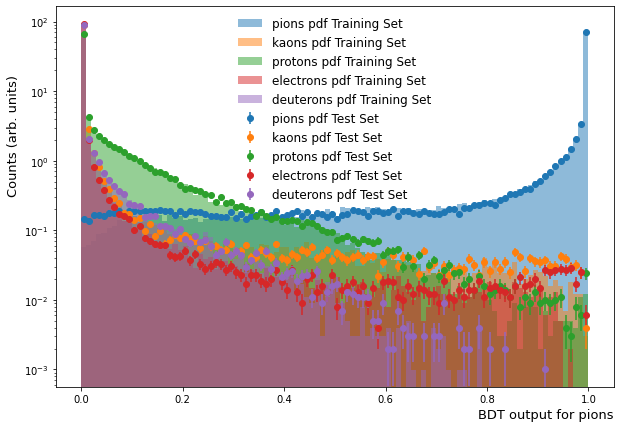

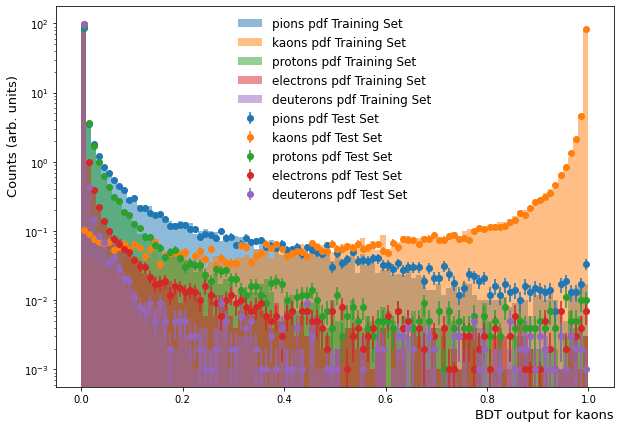

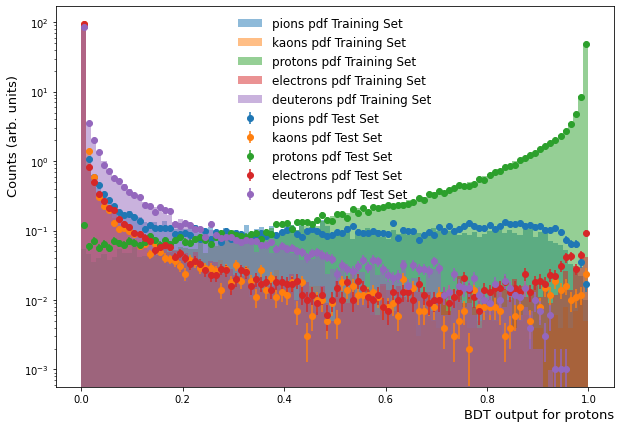

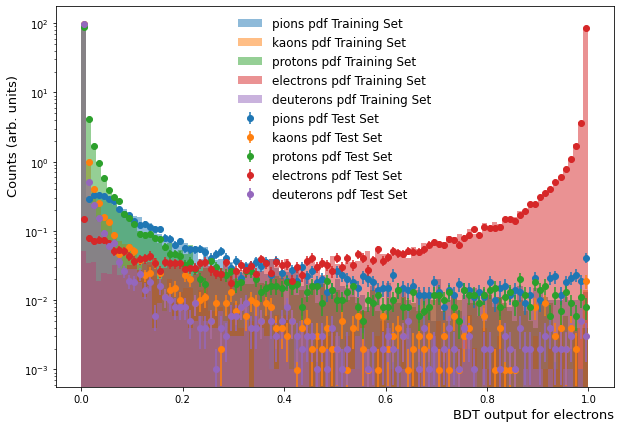

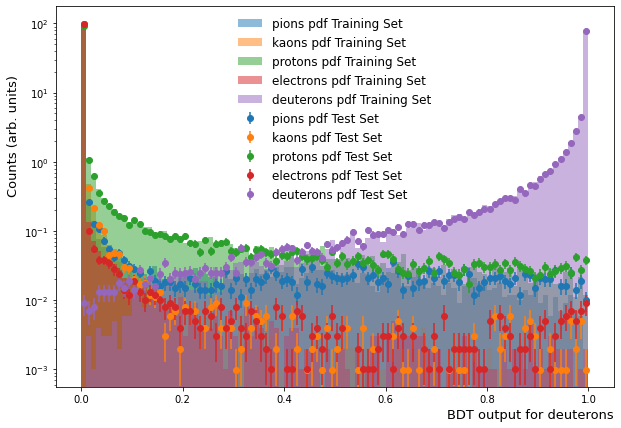

In [118]:
plt.rcParams["figure.figsize"] = (10, 7)

ml_out_fig = plot_utils.plot_output_train_test(model_hdl, train_test_data, 100, 
                                               False, leg_labels, True, density=True)

The quality of the algorithm can be also studied with the ROC curve, that can be plotted with the method _plot\_utils_._plot\_roc\_train\_test_. A good model classifier is characterised by a large area under the ROC curve (_ROC AUC_).

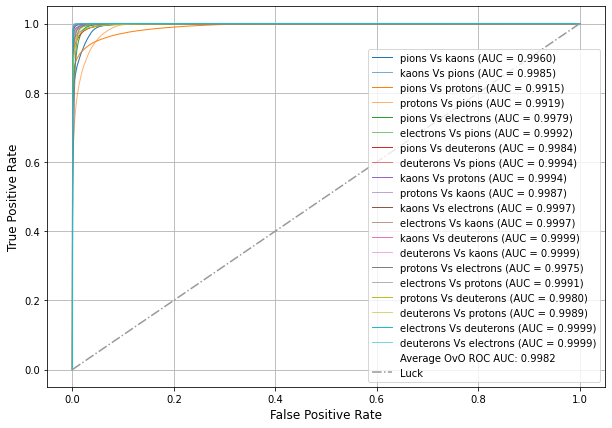

In [119]:
roc_train_test_fig = plot_utils.plot_roc(train_test_data[3], y_pred_test, None, leg_labels, multi_class_opt="ovo")

### **Visualise the result**

In order to visualise better the performance of our BDT model, the $\mathrm{d}E/\mathrm{d}x$ of TPC as a function of momentum is plotted before and after a selection on the BDT outputs of score > 0.90 for each of the classes. This is done for the test set only, in order to avoid biased results due to overtraining.

In [120]:
threshold = 0.9

df_test_with_scores = train_test_data[2].copy()
df_test_with_scores["BDTpion"] = y_pred_test[:, 0]
df_test_with_scores["BDTkaon"] = y_pred_test[:, 1]
df_test_with_scores["BDTproton"] = y_pred_test[:, 2]
df_test_with_scores["BDTelectron"] = y_pred_test[:, 3]
df_test_with_scores["BDTdeuteron"] = y_pred_test[:, 4]
df_test_with_scores["labels"] = train_test_data[3]
hdl_test_with_scores = TreeHandler()
hdl_test_with_scores.set_data_frame(df_test_with_scores)

hdl_test_sel_pions = hdl_test_with_scores.get_subset(f"BDTpion > {threshold}")
hdl_test_sel_kaons = hdl_test_with_scores.get_subset(f"BDTkaon > {threshold}")
hdl_test_sel_protons = hdl_test_with_scores.get_subset(f"BDTproton > {threshold}")
hdl_test_sel_electrons = hdl_test_with_scores.get_subset(f"BDTelectron > {threshold}")
hdl_test_sel_deuterons = hdl_test_with_scores.get_subset(f"BDTdeuteron > {threshold}")

After the application of the model to the data and the consequent selection on the output scores mostly the desired particle is selected, apart from some small contamination

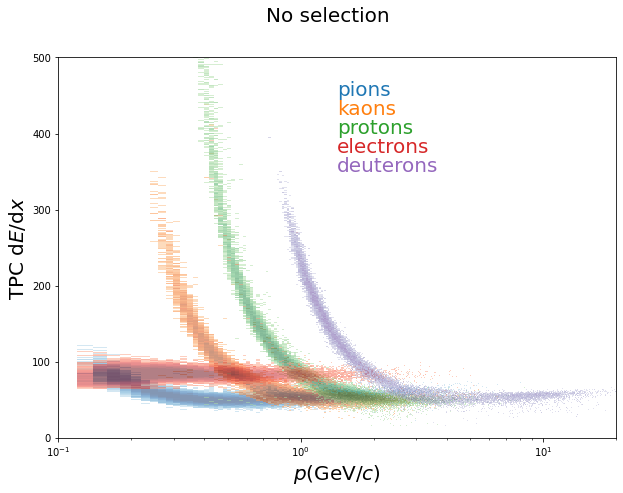

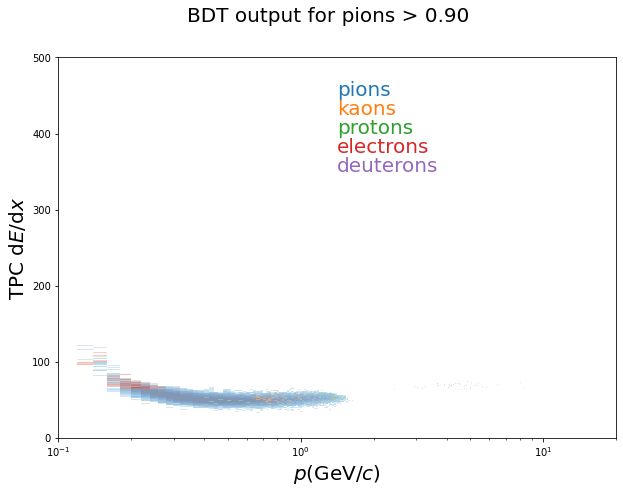

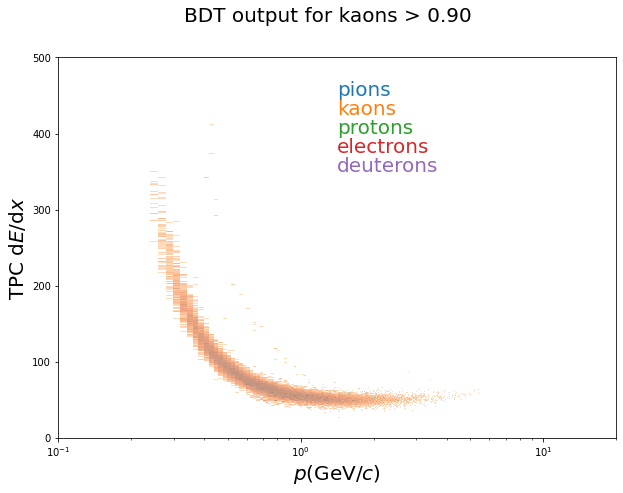

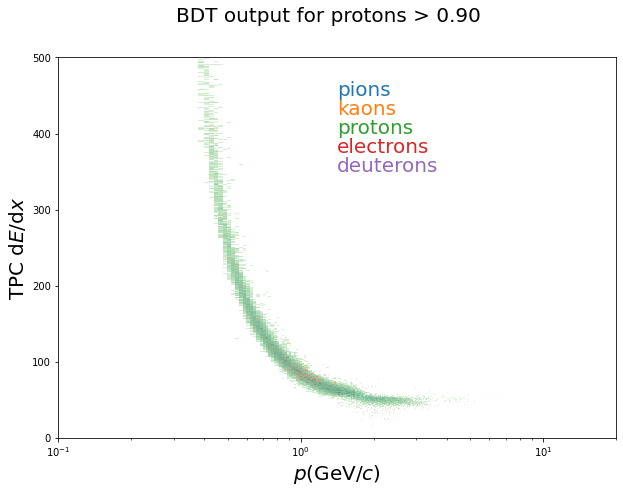

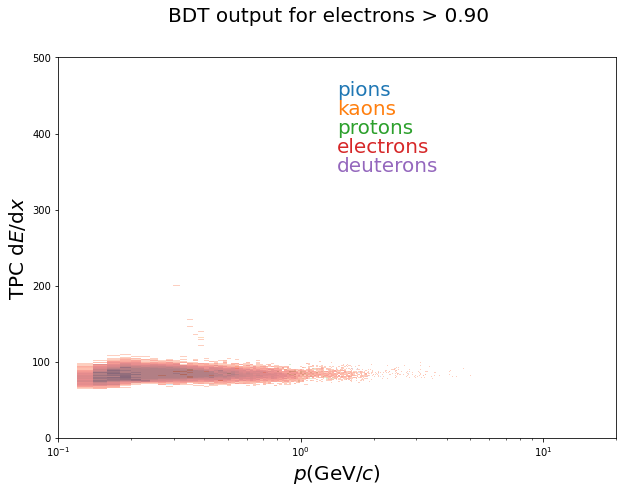

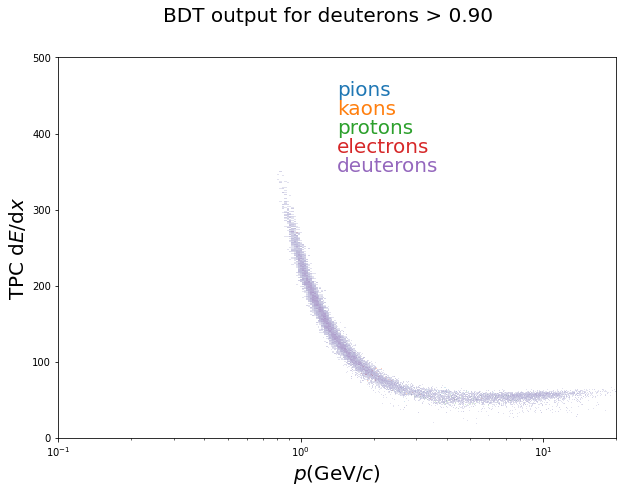

In [122]:
hdl_list = [hdl_test_with_scores, hdl_test_sel_pions, hdl_test_sel_kaons, hdl_test_sel_protons, hdl_test_sel_electrons, hdl_test_sel_deuterons]
colors_list = ["Blues", "Oranges", "Greens", "Reds", "Purples"]
cmap = plt.cm.get_cmap("tab10")

fig, patches = [], []
for i_pad, hdl in enumerate(hdl_list):
    fig.append(plt.figure(figsize=(10, 7)))
    patches.append([])
    if i_pad == 0:
        plt.suptitle("No selection", fontsize=20)
    else:
        plt.suptitle(f"BDT output for {leg_labels[i_pad - 1]} > {threshold:0.2f}", fontsize=20)
        
    for i_part, (col, lab) in enumerate(zip(colors_list, leg_labels)):
        hdl_part = hdl.get_subset(f"labels == {i_part}")
        df = hdl_part.get_data_frame()
        plt.hist2d(df["p"].to_numpy(), df["dEdxTPC"].to_numpy(),  cmap=plt.get_cmap(col), alpha=0.5,
                   range=np.array([(1.e-1, 2e1), (0, 500)]), bins=(1000, 1000), norm=LogNorm(1.e-1, 1.e2))
        plt.xscale('log')
        plt.ylabel(r"TPC $\mathrm{d}E/\mathrm{d}x$", fontsize=20)
        plt.xlabel(r"$p (\mathrm{GeV}/c)$", fontsize=20)
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        plt.xlim((1e-1, 2e+1))
        plt.text(0.5, 0.9 - i_part * 0.05, lab, color=cmap(i_part), fontsize=20, transform=fig[i_pad].gca().transAxes)

    plt.plot()
